In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from scripts.sam_value_counts import sam_dataframe_cols_value_count_analysis, sam_dataframe_markup_value_counts
from scripts.sam_confusion_matrix import sam_plot_confusion_matrix, sam_confusion_maxtrix
from scripts.sam_variance_check import get_low_variance_columns
from scripts.tools import check_metric, data_transformations, df_check_stats, game

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.decomposition import PCA

np.set_printoptions(precision=5)
np.random.seed(69572)
plt.style.use('ggplot')
sns.set(color_codes=True)

%matplotlib inline

In [56]:
# data collection
RAW_X = pd.read_csv('data/traning_set_values.csv', index_col='id')
RAW_y = pd.read_csv('data/training_set_labels.csv', index_col='id')
RAW_TEST_X = pd.read_csv('data/test_set_values.csv', index_col='id')

df_check_stats(RAW_X, RAW_y, RAW_TEST_X)

Data Frame Shape: (59400, 39) TotColumns: 39 ObjectCols: 0
Data Frame Shape: (59400, 1) TotColumns: 1 ObjectCols: 0
Data Frame Shape: (14850, 39) TotColumns: 39 ObjectCols: 0


In [57]:
RAW_X.dtypes == 'O'

# bool columns
tmp = ['public_meeting', 'permit']
RAW_X[tmp] = RAW_X[tmp].fillna(True)
RAW_TEST_X[tmp] = RAW_TEST_X[tmp].fillna(True)

# object columns list
obj_cols = RAW_X.dtypes[RAW_X.dtypes == 'O'].index.tolist()

# object columns
RAW_X[obj_cols] = RAW_X[obj_cols].fillna('Other')
RAW_TEST_X[obj_cols] = RAW_TEST_X[obj_cols].fillna('Other')

In [58]:
# Just assining new names to transformed dataframe pointers
X, y, TEST_X = data_transformations(RAW_X, RAW_y, RAW_TEST_X)

In [59]:
# benchmark
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42, stratify=y)
clf = game(X_train, X_test, y_train, y_test, algo='rf', )

------------------------------------------------
AC Score: 0.984848484848 F1 Score: 0.984906895824
------------------------------------------------
AC Score: 0.799865319865 F1 Score: 0.806462319165


In [65]:
sam_pickle_save(X, y, TEST_X, prefix="tmp/Iteration0_")
df_check_stats(X, y, TEST_X)

SAVE PREFIX USED:  tmp/Iteration0_
Data Frame Shape: (59400, 39) TotColumns: 39 ObjectCols: 0
Numpy Array Size: 59400
Data Frame Shape: (14850, 39) TotColumns: 39 ObjectCols: 0


In [67]:
# benchmark
gbt_clf = game(X_train, X_test, y_train, y_test, algo='gb')

------------------------------------------------
AC Score: 0.755757575758 F1 Score: 0.77760116502
------------------------------------------------
AC Score: 0.754074074074 F1 Score: 0.776074770727


In [ ]:
knn_clf = game(X_train, X_test, y_train, y_test, algo='knn')

In [69]:
df_check_stats(X, y, TEST_X)

Data Frame Shape: (59400, 39) TotColumns: 39 ObjectCols: 0
Numpy Array Size: 59400
Data Frame Shape: (14850, 39) TotColumns: 39 ObjectCols: 0


In [85]:
X, y, TEST_X = sam_pickle_load(prefix="tmp/Iteration0_")
df_check_stats(X, y, TEST_X)

LOAD PREFIX USED:  tmp/Iteration0_
Data Frame Shape: (59400, 39) TotColumns: 39 ObjectCols: 0
Numpy Array Size: 59400
Data Frame Shape: (14850, 39) TotColumns: 39 ObjectCols: 0


In [86]:
# Variance Threshold
X, removed_features, ranking_variance_thresholds = get_low_variance_columns(dframe=X, threshold=(0.85 * (1 - 0.85)), autoremove=True)
TEST_X.drop(removed_features, axis=1, inplace=True)

# Benchmark
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42, stratify=y)
clf = game(X_train, X_test, y_train, y_test, algo='rf', show_train_scores=False)

Finding low-variance features.
Found 2 low-variance columns.
                
Removing low-variance features.
Reassembling the dataframe (with low-variance features removed).
Succesfully removed low-variance columns.
------------------------------------------------
AC Score: 0.795084175084 F1 Score: 0.802037991324


In [74]:
print(removed_features)

['public_meeting', 'recorded_by']


In [68]:
def sam_pickle_save(df_x, df_y, df_test_x, prefix="tmp/Iteration1_"):
    print('SAVE PREFIX USED: ', prefix)
    pickle.dump(df_x, open(prefix + 'df_x.pkl', 'wb'))
    pickle.dump(df_y, open(prefix + 'df_y.pkl', 'wb'))
    pickle.dump(df_test_x, open(prefix + 'df_test_x.pkl', 'wb'))
    return

def sam_pickle_load(prefix='tmp/Iteration1_'):
    print('LOAD PREFIX USED: ', prefix)
    df_x = pickle.load(open(prefix + 'df_x.pkl', 'rb'))
    df_y = pickle.load(open(prefix + 'df_y.pkl', 'rb'))
    df_test_x = pickle.load(open(prefix + 'df_test_x.pkl', 'rb'))
    return df_x, df_y, df_test_x

In [71]:
sam_pickle_save(X, y, TEST_X, prefix="tmp/Iteration1_vt_")

SAVE PREFIX USED:  tmp/Iteration1_vt_


In [117]:
X, y, TEST_X = sam_pickle_load(prefix='tmp/Iteration1_vt_')

len(X.columns)

LOAD PREFIX USED:  tmp/Iteration1_vt_


37

In [121]:
# KBest Selection
def find_kbest_cols_count(start=10, stop=37, step=3):
    for kbest_cols in range(start, stop, step):
        print('============================================================', kbest_cols)

        # Load Data
        X, y, TEST_X = sam_pickle_load(prefix='tmp/Iteration1_vt_')

        fit = SelectKBest(score_func=chi2, k=kbest_cols).fit(X, y)
        cols_names = X.columns
        kbest_selected_cols =  [_ for _ in cols_names[:kbest_cols]]

        # transformation
        # X = pd.DataFrame(fit.transform(X))
        # TEST_X = pd.DataFrame(fit.transform(TEST_X))

        # check
        # df_check_stats(X, y)

        # benchmark
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42, stratify=y)
        clf = game(X_train, X_test, y_train, y_test, algo='rf', show_train_scores=False)
        return fit, kbest_selected_cols

In [87]:
find_kbest_cols_count(start=10, stop=37, step=3)

============================================================ 10
LOAD PREFIX USED:  tmp/Iteration1_vt_
------------------------------------------------
AC Score: 0.711919191919 F1 Score: 0.720536764767
============================================================ 13
LOAD PREFIX USED:  tmp/Iteration1_vt_
------------------------------------------------
AC Score: 0.726734006734 F1 Score: 0.734890085175
============================================================ 16
LOAD PREFIX USED:  tmp/Iteration1_vt_
------------------------------------------------
AC Score: 0.757171717172 F1 Score: 0.764712247986
============================================================ 19
LOAD PREFIX USED:  tmp/Iteration1_vt_
------------------------------------------------
AC Score: 0.761279461279 F1 Score: 0.769056776288
============================================================ 22
LOAD PREFIX USED:  tmp/Iteration1_vt_
------------------------------------------------
AC Score: 0.76303030303 F1 Score: 0.769985851

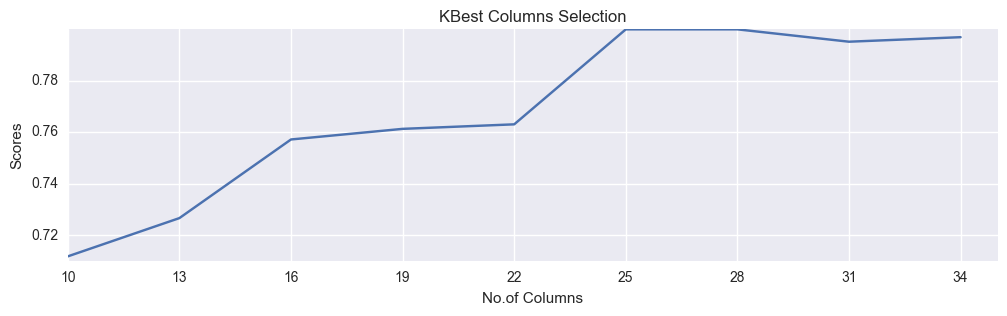

In [110]:
data = '''
============================================================ 10
LOAD PREFIX USED:  tmp/Iteration1_vt_
------------------------------------------------
AC Score: 0.711919191919 F1 Score: 0.720536764767
============================================================ 13
LOAD PREFIX USED:  tmp/Iteration1_vt_
------------------------------------------------
AC Score: 0.726734006734 F1 Score: 0.734890085175
============================================================ 16
LOAD PREFIX USED:  tmp/Iteration1_vt_
------------------------------------------------
AC Score: 0.757171717172 F1 Score: 0.764712247986
============================================================ 19
LOAD PREFIX USED:  tmp/Iteration1_vt_
------------------------------------------------
AC Score: 0.761279461279 F1 Score: 0.769056776288
============================================================ 22
LOAD PREFIX USED:  tmp/Iteration1_vt_
------------------------------------------------
AC Score: 0.76303030303 F1 Score: 0.769985851326
============================================================ 25
LOAD PREFIX USED:  tmp/Iteration1_vt_
------------------------------------------------
AC Score: 0.799797979798 F1 Score: 0.806818418096
============================================================ 28
LOAD PREFIX USED:  tmp/Iteration1_vt_
------------------------------------------------
AC Score: 0.799797979798 F1 Score: 0.806270223927
============================================================ 31
LOAD PREFIX USED:  tmp/Iteration1_vt_
------------------------------------------------
AC Score: 0.795016835017 F1 Score: 0.802364133642
============================================================ 34
LOAD PREFIX USED:  tmp/Iteration1_vt_
------------------------------------------------
AC Score: 0.796767676768 F1 Score: 0.803839413982
'''

data_k_selections = []
data_k_ac_scores = []
data_k_f1_scores = []

for line in data.strip().splitlines():
    if line.startswith('===='):
        data_k_selections.append(int(line.split()[-1]))
    if line.startswith('AC Score'):
        line = line.split()
        data_k_ac_scores.append(float(line[2]))
        data_k_f1_scores.append(float(line[-1]))

# print(data_k_selections)
# print(data_k_ac_scores)
# print(data_k_f1_scores)

plt.figure(figsize=(12, 3))
plt.plot(data_k_selections, data_k_ac_scores)
plt.xticks(data_k_selections)
plt.xlabel('No.of Columns')
plt.ylabel('Scores')
plt.title('KBest Columns Selection')

In [122]:
# KBest Selection
find_kbest_cols_count(start=23, stop=28, step=1)

============================================================ 23
LOAD PREFIX USED:  tmp/Iteration1_vt_
------------------------------------------------
AC Score: 0.798249158249 F1 Score: 0.80539129644
============================================================ 24
LOAD PREFIX USED:  tmp/Iteration1_vt_
------------------------------------------------
AC Score: 0.79569023569 F1 Score: 0.802599368819
============================================================ 25
LOAD PREFIX USED:  tmp/Iteration1_vt_
------------------------------------------------
AC Score: 0.799797979798 F1 Score: 0.806818418096
============================================================ 26
LOAD PREFIX USED:  tmp/Iteration1_vt_
------------------------------------------------
AC Score: 0.798316498316 F1 Score: 0.804709836423
============================================================ 27
LOAD PREFIX USED:  tmp/Iteration1_vt_
------------------------------------------------
AC Score: 0.799057239057 F1 Score: 0.8059701558

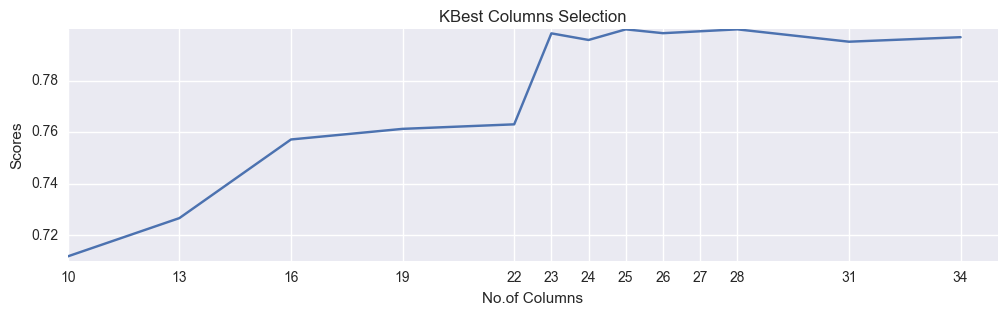

In [112]:
data = '''
============================================================ 10
LOAD PREFIX USED:  tmp/Iteration1_vt_
------------------------------------------------
AC Score: 0.711919191919 F1 Score: 0.720536764767
============================================================ 13
LOAD PREFIX USED:  tmp/Iteration1_vt_
------------------------------------------------
AC Score: 0.726734006734 F1 Score: 0.734890085175
============================================================ 16
LOAD PREFIX USED:  tmp/Iteration1_vt_
------------------------------------------------
AC Score: 0.757171717172 F1 Score: 0.764712247986
============================================================ 19
LOAD PREFIX USED:  tmp/Iteration1_vt_
------------------------------------------------
AC Score: 0.761279461279 F1 Score: 0.769056776288
============================================================ 22
LOAD PREFIX USED:  tmp/Iteration1_vt_
------------------------------------------------
AC Score: 0.76303030303 F1 Score: 0.769985851326
============================================================ 23
LOAD PREFIX USED:  tmp/Iteration1_vt_
------------------------------------------------
AC Score: 0.798249158249 F1 Score: 0.80539129644
============================================================ 24
LOAD PREFIX USED:  tmp/Iteration1_vt_
------------------------------------------------
AC Score: 0.79569023569 F1 Score: 0.802599368819
============================================================ 25
LOAD PREFIX USED:  tmp/Iteration1_vt_
------------------------------------------------
AC Score: 0.799797979798 F1 Score: 0.806818418096
============================================================ 26
LOAD PREFIX USED:  tmp/Iteration1_vt_
------------------------------------------------
AC Score: 0.798316498316 F1 Score: 0.804709836423
============================================================ 27
LOAD PREFIX USED:  tmp/Iteration1_vt_
------------------------------------------------
AC Score: 0.799057239057 F1 Score: 0.805970155845
============================================================ 28
LOAD PREFIX USED:  tmp/Iteration1_vt_
------------------------------------------------
AC Score: 0.799797979798 F1 Score: 0.806270223927
============================================================ 31
LOAD PREFIX USED:  tmp/Iteration1_vt_
------------------------------------------------
AC Score: 0.795016835017 F1 Score: 0.802364133642
============================================================ 34
LOAD PREFIX USED:  tmp/Iteration1_vt_
------------------------------------------------
AC Score: 0.796767676768 F1 Score: 0.803839413982
'''

data_k_selections = []
data_k_ac_scores = []
data_k_f1_scores = []

for line in data.strip().splitlines():
    if line.startswith('===='):
        data_k_selections.append(int(line.split()[-1]))
    if line.startswith('AC Score'):
        line = line.split()
        data_k_ac_scores.append(float(line[2]))
        data_k_f1_scores.append(float(line[-1]))

# print(data_k_selections)
# print(data_k_ac_scores)
# print(data_k_f1_scores)

plt.figure(figsize=(12, 3))
plt.plot(data_k_selections, data_k_ac_scores)
plt.xticks(data_k_selections)
plt.xlabel('No.of Columns')
plt.ylabel('Scores')
plt.title('KBest Columns Selection')

In [124]:
# KBEST SELECTION

kbest_cols = 25
print('============================================================', kbest_cols)

# Load Data
X, y, TEST_X = sam_pickle_load(prefix='tmp/Iteration1_vt_')

fit = SelectKBest(score_func=chi2, k=kbest_cols).fit(X, y)
cols_names = X.columns
kbest_selected_cols =  [_ for _ in cols_names[:kbest_cols]]

# transformation
X = pd.DataFrame(fit.transform(X))
TEST_X = pd.DataFrame(fit.transform(TEST_X))

# check
df_check_stats(X, y)

# benchmark
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42, stratify=y)
clf = game(X_train, X_test, y_train, y_test, algo='rf', show_train_scores=False)

============================================================ 25
LOAD PREFIX USED:  tmp/Iteration1_vt_
Data Frame Shape: (59400, 25) TotColumns: 25 ObjectCols: 0
Numpy Array Size: 59400
------------------------------------------------
AC Score: 0.799797979798 F1 Score: 0.806818418096


In [125]:
sam_pickle_save(X, y, TEST_X, prefix='tmp/Iteration1_vt_kb_')

SAVE PREFIX USED:  tmp/Iteration1_vt_kb_


In [130]:
X, y, TEST_X = sam_pickle_load(prefix='tmp/Iteration1_vt_kb_')
df_check_stats(X, y, TEST_X)

LOAD PREFIX USED:  tmp/Iteration1_vt_kb_
Data Frame Shape: (59400, 25) TotColumns: 25 ObjectCols: 0
Numpy Array Size: 59400
Data Frame Shape: (14850, 25) TotColumns: 25 ObjectCols: 0


In [126]:
# PCA
from sklearn.decomposition import PCA

In [132]:
pca = PCA()
fit = pca.fit(X)

X = fit.transform(X)

# benchmark
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42, stratify=y)
clf = game(X_train, X_test, y_train, y_test, algo='rf', show_train_scores=False)

------------------------------------------------
AC Score: 0.779393939394 F1 Score: 0.787564863498


In [144]:
X[:, :10].shape

(59400, 10)